In [2]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.5.1+cu121
True


In [1]:
# Imports here

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import  datasets, transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [3]:
data_dir ="/kaggle/input/oxford-102-flower-dataset/102 flower/flowers"
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [6]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(50),
                                              transforms.RandomResizedCrop(224),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                   [0.229, 0.224, 0.225])]),

    'valid': transforms.Compose([transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                     [0.229, 0.224, 0.225])]),

    'test' : transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])])
                  }
# Load the datasets with ImageFolder
image_datasets ={x: datasets.ImageFolder(f"{data_dir}/{x}", transform =data_transforms[x]) for x in ['train','valid','test']}

# Using the image datasets and the transforms, define the dataloaders
dataloaders ={x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 32, shuffle = True) for x in ['train','valid','test']}

In [43]:
import json

with open('/kaggle/input/cat-to-name-json/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [9]:
# TODO: Build and train your network
model = models.mobilenet_v2(weights = True)

for param in model.features.parameters():
    param.requires_grad  = False

#Define a new, untrained feed-forward network as a classifier
model.classifier = nn.Sequential(
    nn.Linear(model.last_channel, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256,102),
    nn.LogSoftmax(dim=1)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#Train the classifier layers using backpropagation

#Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


# Training Parameters
epochs = 12

# Training Loop
for epoch in range(epochs):
    train_loss = 0
    correct, total = 0, 0  # Track accuracy

    model.train()
    for images, labels in dataloaders['train']:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients
        output = model(images)  # Forward pass
        loss = criterion(output, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()  # Accumulate loss
        _, preds = torch.max(output, 1)  # Get predictions
        correct += (preds == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Total samples

    train_accuracy = correct / total  # Calculate accuracy
    avg_train_loss = train_loss / len(dataloaders['train'])  # Average loss

    # Validation Loop (No Gradient Update)
    valid_loss = 0
    correct, total = 0, 0

    model.eval()
    with torch.no_grad():
        for images, labels in dataloaders['valid']:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()

            _, preds = torch.max(output, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    valid_accuracy = correct / total  # Validation Accuracy
    avg_valid_loss = valid_loss / len(dataloaders['valid'])  # Avg validation loss

    # Print results after each epoch
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.3f} | "
          f"Validation Loss: {avg_valid_loss:.3f} | "
          f"Train Accuracy: {train_accuracy:.2%} | Validation Accuracy: {valid_accuracy:.2%}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 154MB/s]


Epoch 1/12 | Train Loss: 3.424 | Validation Loss: 1.771 | Train Accuracy: 25.46% | Validation Accuracy: 60.51%
Epoch 2/12 | Train Loss: 1.857 | Validation Loss: 0.893 | Train Accuracy: 53.48% | Validation Accuracy: 79.95%
Epoch 3/12 | Train Loss: 1.415 | Validation Loss: 0.622 | Train Accuracy: 63.06% | Validation Accuracy: 86.43%
Epoch 4/12 | Train Loss: 1.177 | Validation Loss: 0.506 | Train Accuracy: 68.54% | Validation Accuracy: 87.29%
Epoch 5/12 | Train Loss: 1.108 | Validation Loss: 0.420 | Train Accuracy: 70.15% | Validation Accuracy: 90.83%
Epoch 6/12 | Train Loss: 1.022 | Validation Loss: 0.427 | Train Accuracy: 71.96% | Validation Accuracy: 89.12%
Epoch 7/12 | Train Loss: 0.964 | Validation Loss: 0.355 | Train Accuracy: 73.82% | Validation Accuracy: 91.20%
Epoch 8/12 | Train Loss: 0.911 | Validation Loss: 0.354 | Train Accuracy: 75.03% | Validation Accuracy: 89.98%
Epoch 9/12 | Train Loss: 0.896 | Validation Loss: 0.345 | Train Accuracy: 74.98% | Validation Accuracy: 91.32%
E

In [10]:
# TODO: Do validation on the test set
test_loss = 0
correct = 0
total = 0

model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation
    for images, labels in dataloaders['test']:  # Use test dataloader
        images, labels = images.to(device), labels.to(device)
        
        output = model(images)  # Forward pass
        loss = criterion(output, labels)  # Compute loss
        
        test_loss += loss.item()

        # Get predicted class
        _, preds = torch.max(output, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

# Compute final test accuracy
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.2%}")


Test Accuracy: 90.84%


In [61]:
# Save the checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),  
    'classifier': model.classifier,  
    'state_dict': model.state_dict(), 
    'class_to_idx': image_datasets['train'].class_to_idx,  # Mapping of classes to indices
    'optimizer_state': optimizer.state_dict(),  
    'epochs': epochs  # Number of epochs trained
}

torch.save(checkpoint, 'checkpoint.pth')  # Save to a file
print("Checkpoint saved!")

#Load and Rebuild the model
def load_checkpoint(path='checkpoint.pth'):
    checkpoint = torch.load('checkpoint.pth')
    model = models.mobilenet_v2(weights=True)
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    return model

model = load_checkpoint('checkpoint.pth')
model.eval()
print("Model successfully Loaded1")


Checkpoint saved!
Model successfully Loaded1


<ipython-input-61-cfd36647c2ff>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pth')


In [33]:
print(hasattr(model, 'class_to_idx'))  # Should print True if class_to_idx exists
index_map = dict(map(reversed, model.class_to_idx.items()))


True


In [34]:

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    # Open image
    image = Image.open(image)

    transform =transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])
    #Apply transformations
    tensr = transform(image)
    #Conv it into numpy array
    np_image =tensr.numpy()                         
    return np_image

Axes(0.125,0.11;0.775x0.77)


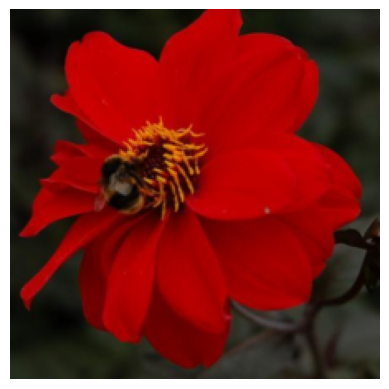

In [83]:
trial_image = '/kaggle/input/oxford-102-flower-dataset/102 flower/flowers/test/56/image_02821.jpg'
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
   

    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    if title:
        ax.set_title(title)
    
    ax.axis('off')
    return ax

# displays preprocessed image
ax =imshow(process_image(trial_image))
print(ax)

(3, 224, 224)


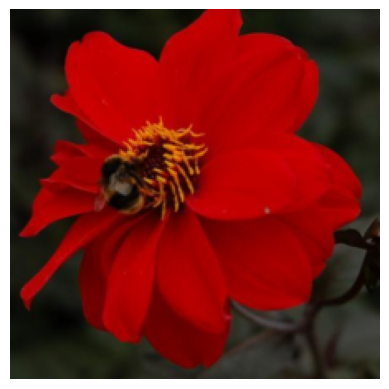

In [84]:
from PIL import Image

# displays original image
image = process_image(trial_image)
# displays preprocessed image
imshow(process_image(trial_image))
print(image.shape)


In [85]:
name_file = '/kaggle/input/cat-to-name-json/cat_to_name.json'
def class_to_label(name_file,classes):
    with open(name_file, 'r') as f:
        class_mapping = json.load(f)
    labels =[]
    for c in classes:
        labels.append(class_mapping[c])
    return labels

<ipython-input-86-dbc4c6fc1e84>:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 2)


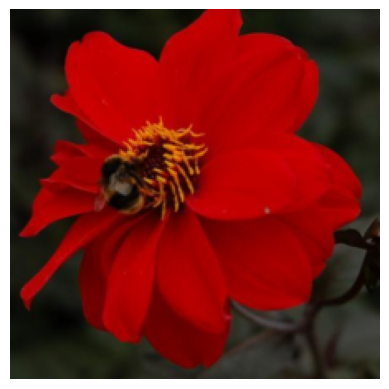

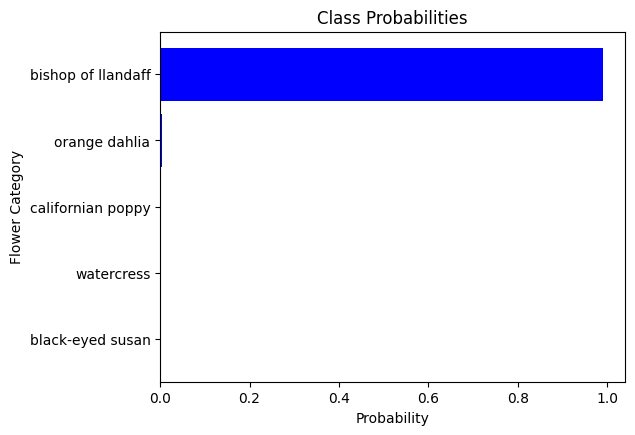

image_02821.jpg
1) 99.71% Bishop Of Llandaff | Class No. 56
2) 0.18% Orange Dahlia | Class No. 59
3) 0.10% Californian Poppy | Class No. 65
4) 0.00% Watercress | Class No. 89
5) 0.00% Black-Eyed Susan | Class No. 63
1) 99.71% Class No. 56 
2) 0.18% Class No. 59 
3) 0.10% Class No. 65 
4) 0.00% Class No. 89 
5) 0.00% Class No. 63 



In [86]:
model.to(device)
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file

    #Image processing
    image = process_image(image_path)  
    p_image = torch.from_numpy(image).float()
    p_image = torch.unsqueeze(p_image,0).to(device).float() # Add batch dimension    
     
    model.to(device)
    model.eval()
    output = model.forward(p_image)
    probab =torch.exp(output)
    #to get top k probabilities and indices
    probs, indices = probab.topk(topk, dim=1)
    list_probs = probs.tolist()[0]
    list_index = indices.tolist()[0]
    classes =[]
    model.train()
    for x in list_index:
        classes.append(index_map[x])
    return list_probs, classes
def print_predictions(probabilities, classes,image,category_names=None):
    # prints out the image
    print(image)
    if category_names:
       labels = class_to_label(category_names,classes)
    for i,(probab,lab,c) in enumerate(zip(probabilities,labels,classes),1):
            print(f'{i}) {probab*100:.2f}% {lab.title()} | Class No. {c}')
    else:
        for i,(probab,c) in enumerate(zip(probabilities,classes),1):
            print(f'{i}) {probab*100:.2f}% Class No. {c} ')
    print('') 

probabilities,classes = predict(trial_image,model, 5)
# Convert class indices to actual flower names
labels = class_to_label(name_file, classes)

image = process_image(trial_image)
imshow(image)
# Set up the figure
plt.figure(figsize=(6, 10))
plt.title("Trial Image")
plt.subplot(2, 1, 2)
plt.barh(labels, width=probs, color='blue')
plt.xlabel("Probability")
plt.ylabel("Flower Category")
plt.title("Class Probabilities")
plt.gca().invert_yaxis()  # Invert y-axis for readability

# Show the plot
plt.show()


# prints out the predictions
print_predictions(probabilities,classes,trial_image.split('/')[-1],name_file)

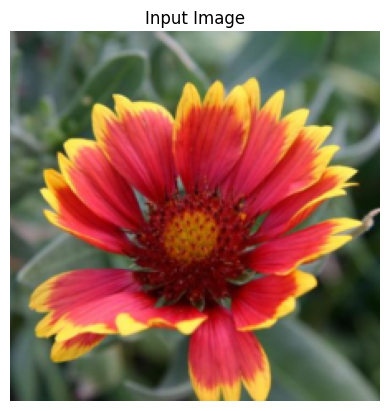

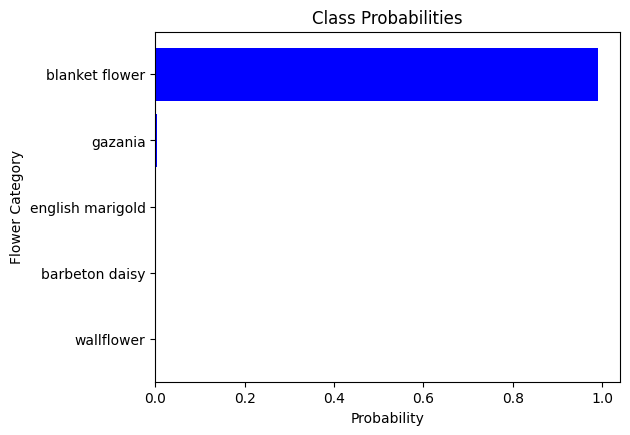

In [62]:
import matplotlib.pyplot as plt

# Define image path
image_path = "/kaggle/input/oxford-102-flower-dataset/102 flower/flowers/test/100/image_07938.jpg"

# Process image
image = process_image(image_path)

# Make predictions
probs, classes = predict(image_path, model)

# Convert class indices to actual names
labels = class_to_label(name_file, classes)

# Display the image
imshow(image)
plt.title("Input Image")
# Set up the figure
plt.figure(figsize=(6, 10))
# Plot probabilities
plt.subplot(2, 1, 2)
plt.barh(labels, width=probs, color='blue')
plt.xlabel("Probability")  # X-axis label
plt.ylabel("Flower Category")  # Y-axis label
plt.title("Class Probabilities")
plt.gca().invert_yaxis()  # Ensure the highest probability class appears at the top

# Show the plot
plt.show()
